# $n_{trk}$ modified Negative Tag

**Motviation:** In the `Flipping-Performance` notebook, I investigated the performance of the flipped and negative tagger, and found that the negative tagger flipped the light discriminant by too much to make it at all usable for the tight working point.

Our hypothesis was that since the NN can use the track multiplicity as a discriminating variable, only using the negative tracks changed the definition of the jet too much, so this was why the negative tag method was epically failing.

But for DIPS, since we have more of a handle of what the network is learning in terms of the hierarchy of information between the tracks and the jets, Dan said in the algorithms meeting that I could try multiplying the output of the sum operation by 2 to keep the l-discriminant of the negative tagger more similar to the nominal one.

I think it's a good idea, and worth a shot!

In [1]:
import numpy as np
import h5py
import sys
import pandas as pd
import xarray as xr

sys.path.append("../..")
from usefulFcts import *
from trainNet import * #myLSTM, myPFN
from plottingFcts import *

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
tag = '_neg2x'

## Step 1: Load in the data for the *nominal* and *flipped* configurations

In [3]:
subDir = 'mc16d_PFlow_ttbar_ip3d'
dataDir = '../../data/' + subDir
vStr = "sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits"
# The pfn model 
dataTagTrain = "3mtrain_15trks_{}".format(vStr)
dataTagTest  = "2mtest_15trks_{}_sd0_rev".format(vStr)

f_name = "{}/data_{}.hdf5".format(dataDir,dataTagTest)
f = h5py.File(f_name,"r")

X = f['X_test'][:]
y = f['y_test'][:]
ix = f['ix_test'][:]

f.close()

jet_df = pd.read_hdf('{}/jet_3mtest_15trks.h5'.format(dataDir), key='jet_df')

assert len(jet_df.index) == X.shape[0]

In [4]:
X_flip = X.copy()

X_flip[:,:,:2] *= -1
X_flip = X_flip[:,::-1]

In [5]:
X_neg = X.copy()

# For the negative version of the tagger, ONLY use the tracks with negative sd0
pos_d0s = (X_neg[:,:,0] > 0)
X_neg[pos_d0s] = 0


In [6]:
modelDir = '../../models/'+subDir
figDir = '../../figures/'

_, nTrks, nFeatures = X.shape

If I'm running in the negative tagger mode, I think it's good to compare the number of tracks that I have for b, c, and l-jets.

In [7]:
dense_sizes = [100] * 3
ppm_sizes = [100,100,128]

In [8]:
lstm = myLSTM(modelDir=modelDir, nFeatures=nFeatures, 
            dataTag=dataTagTrain+'_sd0_rev', 
            nHidden=100,loadModel=True,nClasses=3)

dips_nom = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
            modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
            dropout=0,batch_norm=True)

dips_neg = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
            modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
            dropout=0,batch_norm=True,neg=True)


Initialize method from myModel()
Loading previously trained LSTM
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file


## Step 2: Overlay the discriminants for each flavor for each of the configurations

In [ ]:
rnn_colors = ['C0','C1','C2']
dips_colors = ['C6','C9','C4']
xlabel = '$D_b = \ln [ p_b / (f_c p_c + (1- f_c)p_l ) ]$'

../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_LSTM_100units_10dense_3out_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_sd0_rev_flip.json
Load in the previously saved efficiency file


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
../../plottingFcts.py:529: RuntimeWarning: divide by zero encountered in true_divide
  ax2.plot((bins[:-1]+bins[1:])/2, n/nFirst, color=kargs['color'] )
../../plottingFcts.py:529: RuntimeWarning: invalid value encountered in true_divide
  ax2.plot((bins[:-1]+bins[1:])/2, n/nFirst, color=kargs['color'] )


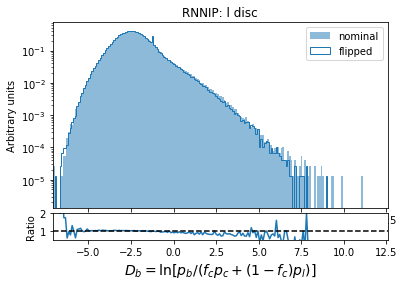

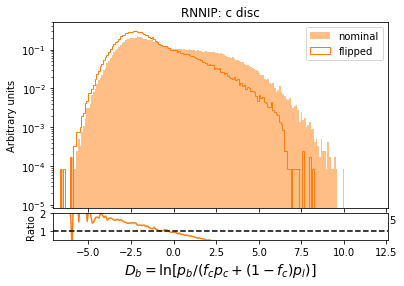

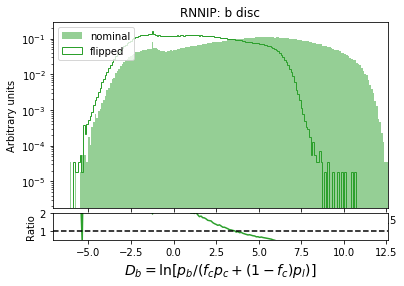

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg2x.json
Load in the previously saved efficiency file
i_eff = 85, teff = 0.8458928986904948
Cut on discriminant at 0.2745671558380103
i_eff = 77, teff = 0.7646247049483427
Cut on discriminant at 1.6755387210845925
i_eff = 72, teff = 0.7029573544900247
Cut on discriminant at 2.5511459493637076
i_eff = 65, teff = 0.5972857911647016
Cut on discriminant at 3.7769960689544675


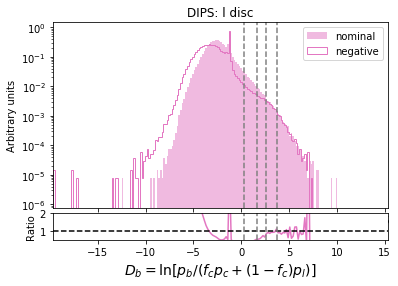

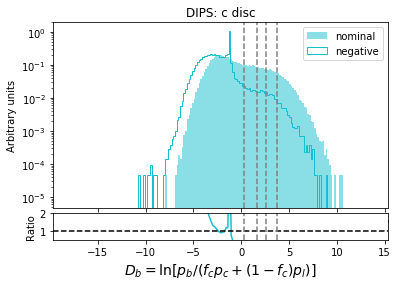

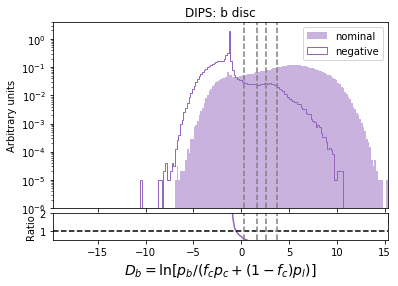

In [ ]:
beffs, ceffs, leffs = [], [], []

'''
RNNIP flipped
'''
# Get the effs for the nominal configuation
(l,c,b), d = getEffs(lstm, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)

# Get the effs for the flipped configuration
(l_flip,c_flip,b_flip), d_flip = getEffs(lstm, X_flip, y, ix, returnDisc=True, figDir=figDir, 
                                         subDir=subDir, modelDir=modelDir,tag='_flip')

leffs += [l, l_flip]
ceffs += [c, c_flip]
beffs += [b, b_flip]

discMax = np.max(np.concatenate((d,d_flip)))
discMin = np.min(np.concatenate((d,d_flip)))
myRange=(discMin,discMax) 
nBins = 200

for yi, flavor, c in zip([0,1,2], ['l','c','b'], rnn_colors):

    hist_arr  = [d[y == yi], d_flip[y == yi]]
    kargs_arr = [{'alpha':0.5,       'color':c, 'label':'nominal'}, 
                 {'histtype':'step', 'color':c, 
                  'label':'flipped'}]

    dtag = flavor+"_disc_rnn_flip"
    plotRatio(hist_arr, kargs_arr, 
              xrange=myRange, nBins=nBins,rrange=(0.5,2),
              xlabel=xlabel, title=('RNNIP: '+flavor+' disc'),
              tag=dtag, figDir=figDir, subDir=subDir)
    

'''
DIPS modified negative
'''
    
# Get the effs for the nominal configuation
(l,c,b), d = getEffs(dips_nom, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)

# Get the effs for the flipped configuration
(l_flip,c_flip,b_flip), d_flip = getEffs(dips_neg, X_neg, y, ix, returnDisc=True, figDir=figDir, 
                                         subDir=subDir, modelDir=modelDir,tag=tag)

leffs += [l, l_flip]
ceffs += [c, c_flip]
beffs += [b, b_flip]

discMax = np.max(np.concatenate((d,d_flip)))
discMin = np.min(np.concatenate((d,d_flip)))
myRange=(discMin,discMax) 
nBins = 200

cuts = []
for WP in [85,77,70,60]:

    cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
    cuts.append(cut)

for yi, flavor, c in zip([0,1,2], ['l','c','b'], dips_colors):

    hist_arr  = [d[y == yi], d_flip[y == yi]]
    kargs_arr = [{'alpha':0.5,       'color':c, 'label':'nominal'}, 
                 {'histtype':'step', 'color':c, 
                  'label':'negative'}]

    dtag = flavor+"_disc_dips"+tag
    plotRatio(hist_arr, kargs_arr, 
              xrange=myRange, nBins=nBins,rrange=(0.5,2),
              xlabel=xlabel, title=('DIPS: '+flavor+' disc'),
              tag=dtag, figDir=figDir, subDir=subDir, cuts=cuts)
    

## Step 3: Look at the $p_T$ performance

**Goal:** At the workshop, Andy said that it was awesome that DIPS leaves the l-discriminant closer to unchanged, because a smaller $K_{LL} = \epsilon_l / \epsilon_l^{flip}$ will bring to smaller extrapolation uncertainties. 

However, to be able to extract the flavor fractions with a flavor sensitive observable (such as the secondary vertex mass), we need to not be overwhelmed by HF composition in the tight (60%) WP. Bing suggested that I look at recreating Table 2 from [l-jet mistag paper](https://cds.cern.ch/record/2314418) to see the flavor composition of the flipped tagger in bins of $p_T$.

<img src="../../figures/l-mistag_Table2.png" width="600">


In [ ]:
pt = jet_df.pt
eta = jet_df.eta

In [ ]:
table = makeTable2([dips_nom,dips_neg], X, X_neg, y, jet_df.pt, jet_df.eta, WPs=[85,60],
                   tag=tag,figDir=figDir,subDir=subDir)
print('DIPS with batch normalization: HF fraction')
table.round(2)

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg2x.json
Load in the previously saved efficiency file
i_eff = 108, teff = 0.8478146196431138
Cut on discriminant at 0.2369736385345469
85 0.2369736385345469
nominal 571138
flipped 93611
nominal HF 523162
flipped HF 74485
i_eff = 83, teff = 0.6047240234655981
Cut on discriminant at 3.6998263549804697
60 3.6998263549804697
nominal 354154
flipped 20302
nominal HF 350976
flipped HF 18244
DIPS with batch normalization: HF fraction


20 GeV < $p_T^{jet}$ < 60 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                 0.88   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.85   
negative 85% WP $|\eta^{jet}|$ < 1.2                                 0.71   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.65   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                 0.98   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.98   
negative 60% WP $|\eta^{jet}|$ < 1.2                                 0.81   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.79   

                                            60 GeV < $p_T^{jet}$ < 100 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                  0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.95   
negative 85% WP $|\eta^{jet}|$ < 1.2                                  0.88   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.83   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                  1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                  0.95   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.93   

                                            100 GeV < $p_T^{jet}$ < 200 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.97   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.96   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.92   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.87   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.97   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.96   

                                            200 GeV < $p_T^{jet}$ < 300 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.93   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.89   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.79   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.98   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.94   

                                            300 GeV < $p_T^{jet}$ < 500 GeV  
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.93  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.85  
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.86  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.67  
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.99  
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.96  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.96

This is a much lower HF fraction for the flipped taggers... seems promising!

In [ ]:
_, flip = effPCBins(dips_neg, X, X_neg, y, tag=tag,figDir=figDir,subDir=subDir)
print('DIPS + batch norm: efficiency')
flip.round(3)

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg2x.json
Load in the previously saved efficiency file
i_eff = 108, teff = 0.8478146196431138
Cut on discriminant at 0.2369736385345469
i_eff = 98, teff = 0.7682194953440002
Cut on discriminant at 1.6221147251129153
i_eff = 91, teff = 0.6999060452510224
Cut on discriminant at 2.591713485717774
i_eff = 83, teff = 0.6047240234655981
Cut on discriminant at 3.6998263549804697
DIPS + batch norm: efficiency


100%-85%  85%-77%  77%-70%  70%-60%   <60%
l-jets     0.982    0.011    0.004    0.003  0.001
c-jets     0.936    0.026    0.015    0.014  0.009
b-jets     0.882    0.035    0.024    0.028  0.030

## Step 4: Efficiency curves

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg2x.json
Load in the previously saved efficiency file


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


i_eff = 85, teff = 0.8458928986904948
Cut on discriminant at 0.2745671558380103
i_eff = 77, teff = 0.7646247049483427
Cut on discriminant at 1.6755387210845925
i_eff = 72, teff = 0.7029573544900247
Cut on discriminant at 2.5511459493637076
i_eff = 65, teff = 0.5972857911647016
Cut on discriminant at 3.7769960689544675


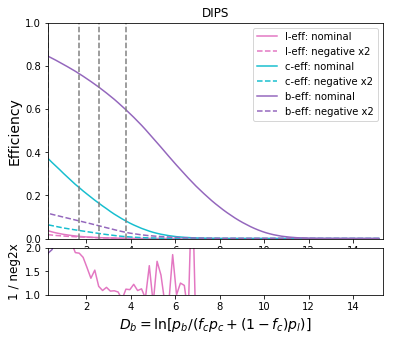

In [ ]:
# Get the effs for the nominal configuation
(_, _, _), d = getEffs(dips_nom, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)

# Get the effs for the flipped configuration
(_, _, _), d_flip = getEffs(dips_neg, X_neg, y, ix, returnDisc=True, figDir=figDir, 
                            subDir=subDir, modelDir=modelDir,tag=tag)

discMax = np.max(np.concatenate((d,d_flip)))
discMin = np.min(np.concatenate((d,d_flip)))
myRange= (discMin,discMax)#(np.min(d),np.max(d)) 
nBins = 200

fig = plt.figure(0,figsize=(6,5))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,0])
ax2 = fig.add_subplot(gs[4:,0])

for yi, flavor, c in zip([0,1,2], ['l','c','b'], dips_colors):


    # Overlay the effs on the same
    n, edg      = np.histogram(d[y == yi], nBins, myRange, density=True)
    n_flip, edg = np.histogram(d_flip[y == yi], nBins, myRange, density=True)


    ax1.plot(edg[:-1][::-1],calculateEff(n), color=c,
             label=flavor+'-eff: nominal')
    ax1.plot(edg[:-1][::-1],calculateEff(n_flip), color=c, linestyle='--',
             label=flavor+'-eff: negative x2')
    ax2.plot(edg[:-1], n / n_flip, color=c)

# It would be super cool to put the pseudo continuous btagging bins on the x-axis
cuts = []
for WP in [85,77,70,60]:

    cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
    cuts.append(cut)

    ax1.plot([cut]*2,[0,1],'grey',linestyle='--')

ax1.set_xlim([cuts[0],discMax])
ax1.set_ylim(0,1)

ax2.set_xlim([cuts[0],discMax])
ax2.set_ylim(1,2)

ax1.legend()
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Efficiency',fontsize=14)
ax1.set_title('DIPS')

ax2.set_xlabel(xlabel,fontsize=14)
ax2.set_ylabel('1 / {}'.format(tag.strip("_")),fontsize=12)

plt.savefig('{}/{}/varyEff_{}{}.pdf'.format(figDir, subDir, 'dips', tag))

plt.show()
#break

## Step 5: Compare the flipped vs nominal configurations

In [ ]:
colors = ['C2']*2 + ['C4']*2 
styles = ['-','--']*2

labels = ['RNNIP' + t for t in ['',': flip']]
labels += ['{}{}'.format(model,config) for model in ['DIPS','DIPS+attention'] for config in ['',': {}'.format(tag.strip("_"))]]

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

plotROC(beffs, leffs, labels,text=text,
        ylabel='l-rej',styles=styles,colors=colors,
        figDir=figDir,subDir=subDir,tag='lrej_'+tag)
plotROC(beffs, ceffs, labels,text=text,
        ylabel='c-rej',styles=styles,colors=colors,ymax=100,
        figDir=figDir,subDir=subDir,tag='crej_'+tag)

../../plottingFcts.py:632: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(teff, np.divide(1,beff), style, color=color, label=label)


Since the performance is so promising with the nominal tagger, it might be worthwhile to check the tagger with attention as well?

In [ ]:
attn_nom = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
            modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
            dropout=0,batch_norm=True,attn=True)

attn_neg = DIPS(ppm_sizes, dense_sizes, timeSteps=nTrks, nFeatures=nFeatures,
            modelDir=modelDir, dataTag=dataTagTrain, nClasses=3, loadModel=True, 
            dropout=0,batch_norm=True,attn=True,neg=True)

Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file
Initialize method from myModel()
weightFile ../../models/mc16d_PFlow_ttbar_ip3d/DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_weights.h5
Loading previously trained DIPS weight file


../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg2x.json
Load in the previously saved efficiency file
i_eff = 98, teff = 0.8516687180416211
Cut on discriminant at 0.18852200508117534
i_eff = 88, teff = 0.7730806323563107
Cut on discriminant at 1.620584630966185
i_eff = 81, teff = 0.7014725497613836
Cut on discriminant at 2.6230284690856926
i_eff = 73, teff = 0.5984793184106907
Cut on discriminant at 3.7686785697936998


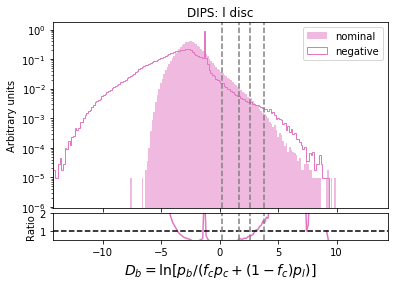

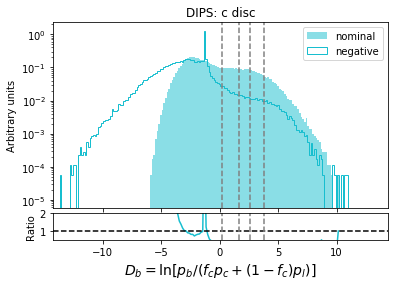

In [ ]:
'''
DIPS modified negative with attention
'''

# Get the effs for the nominal configuation
(l,c,b), d = getEffs(attn_nom, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)

# Get the effs for the flipped configuration
(l_flip,c_flip,b_flip), d_flip = getEffs(attn_neg, X_neg, y, ix, returnDisc=True, figDir=figDir, 
                                         subDir=subDir, modelDir=modelDir,tag=tag)

leffs += [l, l_flip]
ceffs += [c, c_flip]
beffs += [b, b_flip]

discMax = np.max(np.concatenate((d,d_flip)))
discMin = np.min(np.concatenate((d,d_flip)))
myRange=(discMin,discMax) 
nBins = 200

cuts = []
for WP in [85,77,70,60]:

    cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
    cuts.append(cut)

for yi, flavor, c in zip([0,1,2], ['l','c','b'], dips_colors):

    hist_arr  = [d[y == yi], d_flip[y == yi]]
    kargs_arr = [{'alpha':0.5,       'color':c, 'label':'nominal'}, 
                 {'histtype':'step', 'color':c, 
                  'label':'negative'}]

    dtag = flavor+"_disc_dips_attn"+tag
    plotRatio(hist_arr, kargs_arr, 
              xrange=myRange, nBins=nBins,rrange=(0.5,2),
              xlabel=xlabel, title=('DIPS: '+flavor+' disc'),
              tag=dtag, figDir=figDir, subDir=subDir,cuts=cuts)
    


In [ ]:
table = makeTable2([attn_nom,attn_neg], X, X_neg, y, jet_df.pt, jet_df.eta, WPs=[85,60],
                   tag=tag,figDir=figDir,subDir=subDir)
print('DIPS with attn neg 2: HF fraction')
table.round(2)

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg2x.json
Load in the previously saved efficiency file
i_eff = 127, teff = 0.8522779142400946
Cut on discriminant at 0.1738759231567384
85 0.1738759231567384
nominal 578960
flipped 106670
nominal HF 526764
flipped HF 83176
i_eff = 94, teff = 0.603390185724917
Cut on discriminant at 3.717514085769654
60 3.717514085769654
nominal 352480
flipped 35005
nominal HF 349660
flipped HF 30538
DIPS with attn neg 2: HF fraction


20 GeV < $p_T^{jet}$ < 60 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                 0.87   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.84   
negative 85% WP $|\eta^{jet}|$ < 1.2                                 0.70   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.64   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                 0.99   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                 0.79   
                1.2 < $|\eta^{jet}|$ < 2.5                           0.75   

                                            60 GeV < $p_T^{jet}$ < 100 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                  0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.95   
negative 85% WP $|\eta^{jet}|$ < 1.2                                  0.86   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.82   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                  1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                            1.00   
negative 60% WP $|\eta^{jet}|$ < 1.2                                  0.93   
                1.2 < $|\eta^{jet}|$ < 2.5                            0.90   

                                            100 GeV < $p_T^{jet}$ < 200 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.97   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.96   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.88   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.82   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             1.00   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.92   

                                            200 GeV < $p_T^{jet}$ < 300 GeV  \
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.96   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.91   
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.80   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.71   
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   1.00   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.99   
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.95   
                1.2 < $|\eta^{jet}|$ < 2.5                             0.87   

                                            300 GeV < $p_T^{jet}$ < 500 GeV  
nominal 85% WP  $|\eta^{jet}|$ < 1.2                                   0.90  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.77  
negative 85% WP $|\eta^{jet}|$ < 1.2                                   0.70  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.56  
nominal 60% WP  $|\eta^{jet}|$ < 1.2                                   0.99  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.97  
negative 60% WP $|\eta^{jet}|$ < 1.2                                   0.93  
                1.2 < $|\eta^{jet}|$ < 2.5                             0.86

In [ ]:
_, flip = effPCBins(attn_neg, X, X_neg, y, tag=tag,figDir=figDir,subDir=subDir)
print('DIPS + batch norm: efficiency')
flip.round(3)

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg2x.json
Load in the previously saved efficiency file
i_eff = 127, teff = 0.8522779142400946
Cut on discriminant at 0.1738759231567384
i_eff = 113, teff = 0.7693970378500883
Cut on discriminant at 1.6772375679016118
i_eff = 104, teff = 0.699762182591908
Cut on discriminant at 2.6436843395233165
i_eff = 94, teff = 0.603390185724917
Cut on discriminant at 3.717514085769654
DIPS + batch norm: efficiency


100%-85%  85%-77%  77%-70%  70%-60%   <60%
l-jets     0.936    0.014    0.004    0.003  0.003
c-jets     0.910    0.029    0.013    0.012  0.018
b-jets     0.865    0.041    0.019    0.021  0.050

../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits.json
Load in the previously saved efficiency file
../../models/mc16d_PFlow_ttbar_ip3d/effs_DIPS_phi_100_100_128_F_100_100_100_3out_bn_attn_3mtrain_15trks_sd0_sz0_nNextToInnHits_nInnHits_nsharedBLHits_nsplitBLHits_nsharedPixHits_nsplitPixHits_nsharedSCTHits_logNorm_ptfrac_dr_norm_nPixHits_nSCTHits_neg2x.json
Load in the previously saved efficiency file


/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide
/gpfs/slac/atlas/fs1/d/nhartman/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


i_eff = 98, teff = 0.8516687180416211
Cut on discriminant at 0.18852200508117534
i_eff = 88, teff = 0.7730806323563107
Cut on discriminant at 1.620584630966185
i_eff = 81, teff = 0.7014725497613836
Cut on discriminant at 2.6230284690856926
i_eff = 73, teff = 0.5984793184106907
Cut on discriminant at 3.7686785697936998


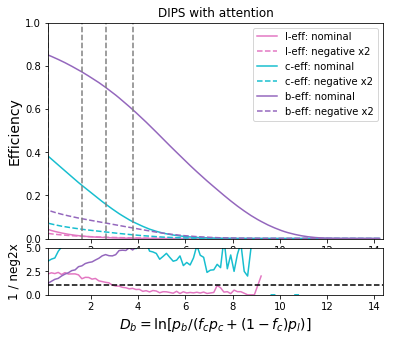

In [ ]:
# Get the effs for the nominal configuation
(_, _, _), d = getEffs(attn_nom, X, y, ix, returnDisc=True, figDir=figDir, subDir=subDir, modelDir=modelDir)

# Get the effs for the flipped configuration
(_, _, _), d_flip = getEffs(attn_neg, X_neg, y, ix, returnDisc=True, figDir=figDir, 
                            subDir=subDir, modelDir=modelDir,tag=tag)

discMax = np.max(np.concatenate((d,d_flip)))
discMin = np.min(np.concatenate((d,d_flip)))
myRange= (discMin,discMax)#(np.min(d),np.max(d)) 
nBins = 200

fig = plt.figure(0,figsize=(6,5))
gs = gridspec.GridSpec(5,1)
ax1 = fig.add_subplot(gs[:4,0])
ax2 = fig.add_subplot(gs[4:,0])

for yi, flavor, c in zip([0,1,2], ['l','c','b'], dips_colors):


    # Overlay the effs on the same
    n, edg      = np.histogram(d[y == yi], nBins, myRange, density=True)
    n_flip, edg = np.histogram(d_flip[y == yi], nBins, myRange, density=True)


    ax1.plot(edg[:-1][::-1],calculateEff(n), color=c,
             label=flavor+'-eff: nominal')
    ax1.plot(edg[:-1][::-1],calculateEff(n_flip), color=c, linestyle='--',
             label=flavor+'-eff: negative x2')
    ax2.plot(edg[:-1], n / n_flip, color=c)

# It would be super cool to put the pseudo continuous btagging bins on the x-axis
cuts = []
for WP in [85,77,70,60]:

    cut = workingPoint(d[y==2], nBins, myRange, WP=.01*WP)
    cuts.append(cut)

    ax1.plot([cut]*2,[0,1],'grey',linestyle='--')

ax1.set_xlim([cuts[0],discMax])
ax1.set_ylim(0,1)

ax2.plot([cuts[0],discMax],[1]*2,'k--')
ax2.set_xlim([cuts[0],discMax])
ax2.set_ylim(0,5)

ax1.legend()
ax1.set_xlabel(xlabel)
ax1.set_ylabel('Efficiency',fontsize=14)
ax1.set_title('DIPS with attention')

ax2.set_xlabel(xlabel,fontsize=14)
ax2.set_ylabel('1 / {}'.format(tag.strip("_")),fontsize=12)

plt.savefig('{}/{}/varyEff_{}{}.pdf'.format(figDir, subDir, 'dips_attn', tag))

plt.show()
#break

In [ ]:
colors = ['C2']*2 + ['C4']*2 + ['C6']*2
styles = ['-','--']*3

labels = ['RNNIP' + t for t in ['',': flip']]
labels += ['{}{}'.format(model,config) for model in ['DIPS','DIPS+attention'] for config in ['',': {}'.format(tag.strip("_"))]]

text="$\mathbf{ATLAS}$ Simulation Internal\n"
text+=r"$\sqrt{s}$ = 13 TeV, mc16d PFlow $t\bar{t}$"

plotROC(beffs, leffs, labels,text=text,
        ylabel='l-rej',styles=styles,colors=colors,
        figDir=figDir,subDir=subDir,tag='lrej_attn'+tag)
plotROC(beffs, ceffs, labels,text=text,
        ylabel='c-rej',styles=styles,colors=colors,ymax=100,
        figDir=figDir,subDir=subDir,tag='crej_attn'+tag)